# Entrega 2
La entrega pasada nos enfocamos en realizar una primera aproximación. Ahora, a no ser que se trabaje con Deep Learning, para hacer un trabajo de clasificación, es necesario tener 2 elementos principales: 
>un descriptor \
>un clasificador

El primero, tal como su nombre lo indica, es el que nos va a permitir describir la imagen, es decir expresar sus características de forma cuantitativa para poder tomar decisiones sobre esta, ese es el vector de TM que hicimos en la entrega pasada. El segundo, cuyo nombre también nos da una pista de su utilidad, sirve para tomar las características que nos da el descriptor y poder asignar clases a las imágenes basándonos en estas. En esta entrega nos enfocaremos en la realización de los descriptores de patrones visuales que hemos visto en la magistral usando como clasificador el vecino mas cercano que hicimos el laboratorio pasado.

## Parte 1: Modificaciones al vecino mas cercano
Lo primero que vamos a hacer será modificar nuestra clase del vecino mas cercano que hicimos la entrega pasada. Esto es debido a que en la entrega pasada en el interior de la funcion tanto de entrenamiento como de predicción se calculaban los descriptores. Sin embargo haremos unas modificaciones a este metodo con el fin de que no se tengan que calcular los descriptores cada vez que se quiera clasificar. 
> **Nota**: los cambios que tienen que hacer a sus codigos son minimos, unicamente es eliminar la linea que calculaba el descriptor y asumir que X es directamente el descriptor


In [2]:
import numpy as np
import scipy.io as sc
from skimage.color import rgb2gray
from skimage.feature import match_template
import cv2
import glob
import os
import sklearn
import matplotlib.pyplot as plt
import pickle
from skimage import color








In [3]:


import numpy as np
class NN_classifier:
    def __init__(self,descriptor):
        '''
        :param descriptor (dict): Diccionario de templates de entrenamiento.
        '''
        self.vectores= [] #atributo del vector de descriptores de entrenamiento
        self.etiquetas=[] #atributo del vector de etiquetas
        
    def fit(self,X,y):
        '''
        :param X: Imagenes de entrenamiento
        :param y: Labels de las imagenes
        :return: self (Trained descriptor)
        '''
        # YOUR CODE HERE
        for i in range(len(X)):
            self.etiquetas.append(y[i])
            self.vectores.append(X[i])
        return self
    
    def predict(self,X):
        '''
        :param X (array): Imagenes a predecir
        :return: Arreglo de etiquetas predichas
        '''
        distancias =[]
        for i in self.vectores:
            distancias.append(np.linalg.norm(np.array(X)-np.array(i)))
        dist_menor = np.where(np.min(distancias))
        etiqueta = self.etiquetas[dist_menor]
            
        # YOUR CODE HERE
        return etiqueta


## Parte 2: Textura
Una de las formas en las que se puede hacer una descripción de la textura de una imagen es mediante el histograma de textones, el cual es una forma de cuantificar la presencia de las textura existentes. Para esto, debemos implementar una función que calcule dicho histograma utilizando un diccionario de textones. Por lo anterior, implementaremos tres funciones auxiliares que nos permitirán obtener sus descriptores de textura. Estas funciones deben realizarlas para poder calcular la respuesta a los filtros, calcular el diccionario de textones y calcular el histograma de textones.

Primeramente vamos a sacar los filtros de interes, los cuales están en el archivo filterbank.mat


In [4]:
str_FileName = "filterbank.mat"
st_File = sc.loadmat(str_FileName)

filterbank = st_File["filterbank"] #Variable que contendrá los filtros para realizar los textones
image =  cv2.resize(cv2.imread(glob.glob(os.path.join('Dataset', 'train', 'Oveja', '*.jpeg'))[0]),(300,300),interpolation=cv2.INTER_AREA) #Variable que contendrá una imagen a color para probar las funciones
# YOUR CODE HERE


In [5]:
import numpy as np
assert not type(filterbank) == dict, f'su banco debería ser una matriz, no un diccionario, revise los elementos y busque el de interes'
print(f'la forma del banco de filtros es: {filterbank.shape}')
assert filterbank.shape == (49,49,18), f'su banco de filtros debería ser de tamaño (49,49,18), no {filterbank.shape}'

la forma del banco de filtros es: (49, 49, 18)


### 2.1 calcular la respuesta a los filtros
Esta primera función tiene como propósito hacer el cálculo de las respuestas a los filtros. Como podrán recordar de lo visto en la magistral, el primer paso para obtener sus textones, así como el mapa de textones de una imagen, es calcular la respuesta de la imagen en escala de grises a cada uno de los filtros que se encuentren en el banco. Finalmente, deben almacenar la respuesta a los filtros de cada uno de los píxeles de la imagen. 
> **Nota**: recuerde que el procedimiento debe ser hecho en escala de grises. Además, vamos a querer que cada pixel sea un dato, por lo que no usaremos una matriz de descriptores sino una lista de ellos.

In [6]:
from scipy import signal
import tqdm
def calculate_filter_response(img,filters):
    '''
    :param img: imagen a color de la cual se va a calcular la respuesta a los filtros
    :param filters: filtros que serán usados
    '''
    imgris = rgb2gray(img)
    tamano=list(imgris.shape)
    tamano.append(18)
    cubo=np.zeros(tuple(tamano))
    for i in range(filters.shape[2]):
        cubo[:,:,i]=signal.correlate2d(imgris,filters[i],mode="same")
    lista=[]
    for i in range(cubo.shape[0]):
        for j in range(cubo.shape[1]):
            listaActual=[]
            for k in range(cubo.shape[2]):
                listaActual.append(cubo[i,j,k])
            lista.append(listaActual)
    lista=np.array(lista)
    return lista
        
    # hacer un cubo de ancho por largo *18
    # aplicar filtro a cada dimension y reemplazar
    # sacar cada pixel e insertarlo a lista.
    #no usar template matching
    

    
   

In [7]:
pixel_response = calculate_filter_response(image,filterbank)
assert len(pixel_response.shape) == 2, f'la respuesta al filtro deberia tener 2 dimensiones, no {len(pixel_response.shape)}'
assert pixel_response.shape == (image.shape[0]*image.shape[1],18),f'la respuesta debería ser de tamaño {(image.shape[0]*image.shape[1],18)} no {pixel_response.shape}'

### 2.2 Calcular el diccionario de textones
Esta segunda función tiene como propósito construir un diccionario de textones. Esta deberá recibir por parámetro el arreglo de píxeles descritos por sus respuestas a los filtros (en las imágenes de entrenamiento). Luego, haciendo uso de un algoritmo de clusterización (comúnmente k-means), agruparlos en lo que serán "tipos de textura". Por último, los centroides de los clusters de textura generados, los cuales serán nuestros textones, deberán ser retornados.

In [8]:
from sklearn.cluster import KMeans
def calculate_texton_dictionary(pixels,n_textons):
    '''
    :param img:
    :param filters:
    '''
    
    centroids = KMeans(n_clusters=n_textons).fit(pixels)
        
    return centroids # este debe el modelo KMeans

In [9]:
texton_dictionary = calculate_texton_dictionary(pixel_response,10)
try:
    texton_dictionary.n_features_in_
except:
    assert False,f'Su modelo no fue entrenado'
assert texton_dictionary.n_features_in_ == 18,f'su modelo tiene un espacio de {texton_dictionary.n_features_in_} dimensiones, no 18 como debería'
assert len(texton_dictionary.labels_)==image.shape[0]*image.shape[1],f'su modelo tiene {len(texton_dictionary.labels_)} puntos, no {image.shape[0]*image.shape[1]}'
assert len(texton_dictionary.cluster_centers_)==10,f'su modelo KMeans fue entrenado con {len(texton_dictionary.cluster_centers_)} clusters, no 10'

### 2.3 Calular histograma de textones
Esta última función generará el mapa de textones de una imagen, en base al cual obtendrán como respuesta el histograma de textones asociado. Esta deberá recibir por parámetro el arreglo de píxeles de la imagen a describir (la respuestas a los filtros) y asociar cada píxel a la etiqueta del centroide (textón) del cluster correspondiente, para finalmente construir y retornar el histograma de textones.
> **nota**: recuerde normalizar el histograma. Y recuerde que aqui tiene un numero finito de valores completos, por lo que debe tener un bin por cada valor

In [10]:

def img_as_float(img):

    imagen = img.astype(float)

    return imagen
def calculate_texton_histogram(pixels,textons):
    '''
    :param pixels: Array de respuesta a los filtros de la imagen 
    :param texton_dictionary: diccionario de textones(Modelo KMeans)
    '''
    etiquetas=textons.predict(pixels)
    histograma=plt.hist(etiquetas,bins=10)
    var1 = ((histograma[0])/(sum(histograma[0])))
    
    #var2 = histograma[1]
    
    return var1

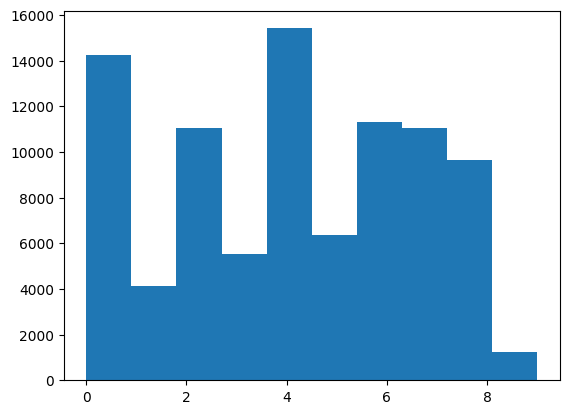

In [11]:
demo_hist = calculate_texton_histogram(pixel_response,texton_dictionary)
assert len(demo_hist)==10, f'el histograma debería tener 10 bins, uno por centroide, no {len(demo_hist)}'
assert np.isclose(np.sum(demo_hist),1,0.05), f'la suma del histogtama debería ser 1, no {np.sum(demo_hist)}'

Este es el unico descriptor que tendremos que entrenar, ya que los demás no dependen sino de las caracteristicas propias de la imagen. Por ello deben recalcular el diccionario de textones usando almenos 1 imagen de cada clase. 

In [12]:
imagenCaballo =  cv2.resize(cv2.imread(glob.glob(os.path.join('Dataset', 'train', 'Caballo', '*.jpeg'))[0]),(300,300),interpolation=cv2.INTER_AREA)
imagenElefante =  cv2.resize(cv2.imread(glob.glob(os.path.join('Dataset', 'train', 'Elefante', '*.jpeg'))[0]),(300,300),interpolation=cv2.INTER_AREA)
imagenGato =  cv2.resize(cv2.imread(glob.glob(os.path.join('Dataset', 'train', 'Gato', '*.jpeg'))[0]),(300,300),interpolation=cv2.INTER_AREA)
imagenPerro =  cv2.resize(cv2.imread(glob.glob(os.path.join('Dataset', 'train', 'Perro', '*.jpeg'))[0]),(300,300),interpolation=cv2.INTER_AREA)
imagenOveja =  cv2.resize(cv2.imread(glob.glob(os.path.join('Dataset', 'train', 'Oveja', '*.jpeg'))[0]),(300,300),interpolation=cv2.INTER_AREA)


animales = np.concatenate((imagenCaballo,imagenElefante,imagenGato,imagenPerro,imagenOveja),axis=0)
texton_dictionary = calculate_texton_dictionary(calculate_filter_response(animales,filterbank),10)


### 2.4 Funcion de calculo de descriptores 
Como ya fue mencionado, haciendo uso de las funciones previamente mencionadas y el/los diccionarios de textones que han generado y almacenado, deberán construir una función que genere el descriptor de textura. Un punto importante que deben tener en cuenta es que usarán esta función no solo para calcular los descriptores, sino para almacenarlos. La razón de esto es que los descriptores en algunos casos pueden tardar un tiempo considerable en ser calculados. Debido a lo anterior, sería computacionalmente costoso y tomaría tiempo en exceso hacer el cálculo de los descriptores en cada una de las entregas. El archivo que deben almacenar debe contener dos listas las cuáles tengan posiciones correspondientes entre ellas, una con la información de los descriptores (uno por imagen) y la otra con la anotación correspondiente. La función debe tener la siguiente estructura:

In [17]:



def texture(images, labels, route, textons):
    '''
    :param images: Imágenes de la cuales se calculará el descriptor.
    :param labels: Etiquetas de las imágenes.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param textons: Diccionario de textones o ruta al archivo que lo contiene.
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''
    features=[]
    label=[]
    histogramas=[]
    for i in range(len(images)):
        respuesta=calculate_filter_response(img_as_float(images[i]),filterbank)
        histograma=calculate_texton_histogram(respuesta, textons)
        histogramas.append(histograma)
        features.append([histograma,labels[i]])
        features[i].append(np.array([histograma,labels[i]],dtype=object))

    fe={"descriptor":histograma,"labels":label}
    fHdl=open(route,"w")
    fHdl.write(str(fe))
    fHdl.close
    return np.array(histogramas)

In [18]:
imgs_elefante_train = [cv2.resize(cv2.imread(i),(300,300),interpolation=cv2.INTER_AREA) for i in glob.glob(os.path.join('Dataset', 'train', 'Elefante', '*.jpeg'))]
imgs_caballo_train = [cv2.resize(cv2.imread(i),(300,300),interpolation=cv2.INTER_AREA) for i in glob.glob(os.path.join('Dataset', 'train', 'Caballo', '*.jpeg'))]
imgs_gato_train = [cv2.resize(cv2.imread(i),(300,300),interpolation=cv2.INTER_AREA) for i in glob.glob(os.path.join('Dataset', 'train', 'Gato', '*.jpeg'))] 
imgs_oveja_train = [cv2.resize(cv2.imread(i),(300,300),interpolation=cv2.INTER_AREA) for i in glob.glob(os.path.join('Dataset', 'train', 'Oveja', '*.jpeg'))]
imgs_perro_train = [cv2.resize(cv2.imread(i),(300,300),interpolation=cv2.INTER_AREA) for i in glob.glob(os.path.join('Dataset', 'train', 'Perro', '*.jpeg'))]

train_images= np.concatenate((imgs_elefante_train[:2],imgs_caballo_train[:2],imgs_gato_train[:2],imgs_oveja_train[:2],imgs_perro_train[:2])) #vector de imagenes de entrenamiento
train_annots = 2*["elefante"]+2*["caballo"]+2*["gato"]+2*["oveja"]+2*["perro"] #vector de anotaciones de entrenamiento
train_texture_route = "features.txt" #ruta donde quieren guardar sus descriptores y labels


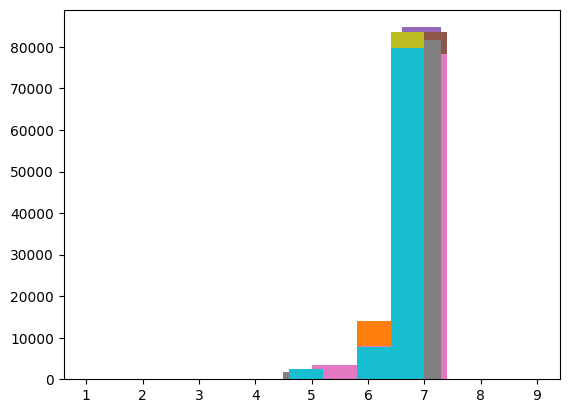

In [19]:
import os
texture_desc = texture(train_images,train_annots,train_texture_route,texton_dictionary)
assert len(texture_desc.shape) == 2 ,f'Su vector de descriptores debe tener 2 dimensiones, no {len(texture_desc.shape)}'
assert texture_desc.shape[0] == len(train_images),f'no existe un decriptor por imagen, hay {texture_desc.shape[0]} descriptores y {len(train_images)} imagenes'
assert not np.isclose(np.std(texture_desc),0,0.001),f'su funcion retorna descriptores similares o identicos'
assert os.path.isfile(train_texture_route),'no se está guardando el archivo'

assert texture_desc.shape[1] ==10,f'su modelo KMeans fue entrenado con {len(texton_dictionary.cluster_centers_)} clusters, no 10'

## Parte 3: Color
Lo primero que se debe realizar, como ya se dijo, es el descriptor mediante el cual vamos a representar una imagen en un vector. En esta entrega se trabajará únicamente con descriptores basados en color. Estos, se basan en representar la imagen según los diferentes colores que la compongan mediante el uso de histogramas, ya que pretende caracterizar la frecuencia de cada una de las intensidades de los colores.

Este descriptor de histogramas de color será el primero que usaremos. La función debe tener la capacidad de calcular tanto histogramas de color conjuntos como histogramas de color concatenados los cuáles pueden obtenerlos utilizando las funciones ```CatColorHistogram``` y ```JointColorHistogram``` que se encuentran a continuación. Además, debe poder utilizar diferentes canales de color como ```rgb```, ```hsv``` y ```lab```. 

In [20]:
# Functions for color histograms




def CatColorHistogram(img, num_bins, min_val=None, max_val=None):
    """
    Calculate concatenated histogram for color images
    By: Natalia Valderrama built on Maria Fernanda Roa's code
    
    Arguments: img (numpy.array) -- 2D color image
    num_bins (array like of ints) -- Number of bins per channel.
    If an int is given, all channels will have same amount of bins.

    Keyword Arguments:
    min_val (array like of ints) -- Minimum intensity range value per channel
    If an int is given, all channels will have same minimum. (default: {None})
    max_val (array like of ints) -- Maximum intensity range value per channel
    If an int is given, all channels will have same maximum. (default: {None})

    Returns: [numpy.array] -- Array containing concatenated color histogram of size num_bins*3.
    """
    assert len(img.shape) == 3, 'img must be a color 2D image'

    #Transform image to float dtype
    img = img_as_float(img)
    _, _, n_channels = img.shape

    #Verify input parameters
    assert isinstance(num_bins, (int, tuple, list, np.array)),'num_bins must be int or array like'

    if isinstance(num_bins, int):
        num_bins = np.array([num_bins]*n_channels)
    else:
        num_bins = np.array(num_bins)

    assert len(num_bins) == n_channels,'num_bins length and number of channels differ'
 
    if min_val is None:
        min_val = np.min(img, (0,1))
    else:
        assert isinstance(min_val, (int, tuple, list, np.array)),'min_val must be int or array like'
        if isinstance(min_val, int):
            min_val = np.array([min_val]*n_channels)
        else:
            min_val = np.array(min_val)

    assert len(min_val) == n_channels,'min_val length and number of channels differ'
    
    min_val = min_val.reshape((1, 1, -1))

    if max_val is None:
        max_val = np.max(img, (0,1))
    else:
        assert isinstance(max_val, (int, tuple, list, np.array)),'max_val must be int or array like'
        if isinstance(max_val, int):
            max_val = np.array([max_val]*n_channels)
        else:
            max_val = np.array(max_val)

    assert len(max_val) == n_channels,'max_val length and number of channels differ'
    max_val = max_val.reshape((1, 1, -1)) + 1e-5
    concat_hist = np.zeros(np.sum(num_bins), dtype=np.int)
    # Scale intensities (intensities are scaled within the range for each channel)
    # Values now are between 0 and 1
    img = (img - min_val) / (max_val - min_val)
    sum_value = 0

    for c in range(n_channels):
        # Calculate index matrix for each channel

        idx_matrix = np.floor(img[...,c]*num_bins[c]).astype('int')
        idx_matrix = idx_matrix.flatten() + sum_value
        sum_value += num_bins[c]
        
        #Create concatenated histogram
        for p in range(len(idx_matrix)):
            concat_hist[idx_matrix[p]] += 1
    
    return concat_hist/np.sum(concat_hist)

def JointColorHistogram(img, num_bins, min_val=None, max_val=None):
    """
    Calculate joint histogram for color images
    By: Maria Fernanda Roa

    Arguments: img (numpy.array) -- 2D color image
    num_bins (array like of ints) -- Number of bins per channel.
    If an int is given, all channels will have same amount of bins.

    Keyword Arguments:
    min_val (array like of ints) -- Minimum intensity range value per channel
    If an int is given, all channels will have same minimum. (default: {None})
    max_val (array like of ints) -- Maximum intensity range value per channel
    If an int is given, all channels will have same maximum. (default: {None})

    Returns: [numpy.array] -- Array containing joint color histogram of size num_bins.
    """

    assert len(img.shape) == 3, 'img must be a color 2D image'

    #Transform image to float dtype
    img = img_as_float(img)
    _, _, n_channels = img.shape

    #Verify input parameters
    assert isinstance(num_bins, (int, tuple, list, np.array)),'num_bins must be int or array like'

    if isinstance(num_bins, int):
        num_bins = np.array([num_bins]*n_channels)
    else:
        num_bins = np.array(num_bins)

    assert len(num_bins) == n_channels,'num_bins length and number of channels differ'
 
    if min_val is None:
        min_val = np.min(img, (0,1))
    else:
        assert isinstance(min_val, (int, tuple, list, np.array)),'min_val must be int or array like'
        if isinstance(min_val, int):
            min_val = np.array([min_val]*n_channels)
        else:
            min_val = np.array(min_val)

    assert len(min_val) == n_channels,'min_val length and number of channels differ'
    
    min_val = min_val.reshape((1, 1, -1))

    if max_val is None:
        max_val = np.max(img, (0,1))
    else:
        assert isinstance(max_val, (int, tuple, list, np.array)),'max_val must be int or array like'
        if isinstance(max_val, int):
            max_val = np.array([max_val]*n_channels)
        else:
            max_val = np.array(max_val)

    assert len(max_val) == n_channels,'max_val length and number of channels differ'
    max_val = max_val.reshape((1, 1, -1)) + 1e-5

    joint_hist = np.zeros(num_bins, dtype=np.int)
    num_bins = num_bins.reshape((1, 1, -1))

    # Scale intensities (intensities are scaled within the range for each channel)
    # Values now are between 0 and 1
    img = (img - min_val) / (max_val - min_val)

    # Calculate index matrix
    idx_matrix = np.floor(img*num_bins).astype('int')
    idx_matrix = idx_matrix.reshape((-1, n_channels))
    
    #Create joint histogram
    for p in range(len(idx_matrix)):
        joint_hist[tuple(idx_matrix[p, :])] += 1
        
    return joint_hist/np.sum(joint_hist)

In [43]:
def color(images, labels, route, tipo, space_bins, color_space):
    '''
    :param images}: Lista con las imágenes (o rutas de las imágenes) a la cuales se les calculará el descriptor.
    :param labels: Lista con las etiquetas de las imágenes pasadas por parámetro.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param tipo: Parámetro que indica el tipo de histograma de color que se calculará, puede ser ``joint'' o ``concat''.
    :param space_bins: Número entero que indica el numero de bins que existirá por cada canal de color.
    :param color_space: Parámetro que indica el espacio de color que se usará, puede ser ``rgb'', ``hsv'', o ``lab''.
    
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''

    features=[]
    label=[]
    histogramas=[]
    for i in range(len(images)):
        print(i)
        label.append(labels[i])
        if color_space == "rgb":
            if tipo == "joint":
                histogramas.append(JointColorHistogram(images[i], space_bins).flatten())
                
                
            
            elif tipo == "concat":
                histogramas.append(CatColorHistogram(images[i], space_bins).flatten())

        
        elif color_space == "hsv":
            bgrimg = cv2.cvtColor(images[i], cv2.COLOR_HSV2BGR)
            if tipo == "joint":
                histogramas.append(JointColorHistogram(bgrimg, space_bins).flatten())
            
            elif tipo == "concat":
                histogramas.append(CatColorHistogram(bgrimg, space_bins).flatten())

        elif color_space == "lab":
            bgrimg1 = cv2.cvtColor(images[i], cv2.COLOR_LAB2BGR)
            if tipo == "joint":
                histogramas.append(JointColorHistogram(bgrimg1, space_bins).flatten())
            elif tipo == "concat":
                histogramas.append(CatColorHistogram(bgrimg1, space_bins).flatten())

        

    fe={"descriptor":histogramas,"labels":label}
    fHdl=open(route,"w")
    fHdl.write(str(fe))
    fHdl.close
    return np.array(histogramas)
    

In [41]:
train_color_route = "color.txt"


In [42]:
import os
color_desc = color(train_images,train_annots,train_color_route,"joint",5,"rgb")
assert len(color_desc.shape) == 2 ,f'Su vector de descriptores debe tener 2 dimensiones, no {len(color_desc.shape)}'
assert color_desc.shape[0] == len(train_images),f'no existe un decriptor por imagen, hay {color_desc.shape[0]} descriptores y {len(train_images)} imagenes'
assert not np.isclose(np.std(color_desc),0,0.001),f'su funcion retorna descriptores similares o identicos'
assert os.path.isfile(train_color_route),'no se está guardando el archivo'

assert color_desc.shape[1] ==5**3,f'su modelo histograma conjunto tiene {color_desc.shape[1]} bins, no {5**3}'
color_desc_cat = color(train_images,train_annots,train_color_route,"concat",5,"rgb")
assert color_desc_cat.shape[1] ==5*3,f'su modelo histograma conjunto tiene {color_desc_cat.shape[1]} bins, no {5*3}'

0
1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17096\2390067883.py:141: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  joint_hist = np.zeros(num_bins, dtype=np.int)


2
3
4
5
6
7
8
9
0
1
2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17096\2390067883.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  concat_hist = np.zeros(np.sum(num_bins), dtype=np.int)


3
4
5
6
7
8
9


## Parte 4: Forma
Finalmente, el último descriptor que utilizaremos en este miniproyecto será basado en forma, para esto usarán el {Histograma de gradientes orientados (HOG) que pueden encontrar en el siguiente link.

https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog. 

Este descriptor es especialmente importante ya que es el único descriptor de los que utilizaremos que tiene en cuenta la posición espacial. Para esto, deberán implementar una función que retorne el histograma de gradientes orientados. En esta, deben poder variar por parámetro 2 parámetros que ustedes establezcan para experimentar. Al igual que las funciones de los otros descriptores, esta función no solo debe retornar los descriptores de las imágenes sino que debe poder almacenarlos en un archivo local.  Esta función debe tener la siguiente estructura:\\

In [ ]:

def shape(images, labels, route, numwin, orientaciones ):
    '''
    :param images: Imágenes de la cuales se calculará el descriptor.
    :param labels: Etiquetas de las imágenes.
    :param route: Ruta donde serán guardados los descriptores junto con las etiquetas.
    :param numwin|||||||||||: Parámetro que determina el numero de ventanas que se van a utilizar para calcular el HOG
    :param orientaciones: Parámetro que determina cuantas oreintaciones se utilizaran para calcular cada gradiente
    
    :return features: Arreglo de etiquetas predichas con los descriptores de las imágenes (el mismo que se almacenará en route)
    '''
    HOG = []
    for i in images and labels:

        if orientaciones == 8:
        
        elif orientaciones == 18:
            

    
    return np.array(features)

In [ ]:
train_shape_route = ''
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
import os
shape_desc = shape(train_images,train_annots,train_shape_route)
assert len(shape_desc.shape) == 2 ,f'Su vector de descriptores debe tener 2 dimensiones, no {len(shape_desc.shape)}'
assert shape_desc.shape[0] == len(train_images),f'no existe un decriptor por imagen, hay {shape_desc.shape[0]} descriptores y {len(train_images)} imagenes'
assert not np.isclose(np.std(shape_desc),0,0.001),f'su funcion retorna descriptores similares o identicos'
assert os.path.isfile(train_shape_route),'no se está guardando el archivo'

## Parte 5: Experimentación
Ahora que ya tenemos implementados nuestros nuevos descriptores de patrones visuales vamos a experimentar con ellos, usando

### 5.1 Textura:
Deben realizar la experimentación variando el número de textones que hay en el diccionario (es decir el numero de bins del histograma). Deben construir por lo menos 4 diccionarios diferentes.**(4 experimentos)**

> Nota: La respuesta a los filtros solo deberían calcularla una vez, guarden esto en archivos y calculen los 4 diccionarios e histogramas usando estos.

### 5.2 Color:
Deben realizar la experimentación en grid 2x3, variando el tipo de histograma que se calcula y el espacio de color respectivamente. **(6 experimentos)**

### 5.3 Forma: 
Deben realizar la experimentación en grid 2x2(es decir las 4 combinaciones de 2 parametros con 2 valores cada uno) escogiendo 2 parámetros de la función para calcular HOG y 2 valores para cada uno de dichos parámetros. **(4 experimentos)**



In [ ]:
# use este espacio para hacer sus experimentos

## Articulo

Una vez realizado el procedimiento es fundamental que se continue con la construcción del articulo de forma progresiva, por lo cual incluiremos lo que hicimos en esta entrega.

### Abordaje

#### Descriptores
Inicialmente explicarán los descriptores, estos no solo los usarán para su método de baseline, sino para el método final. Para esta entrega, describan los 3 descriptores, además de los parámetros que variaron y su propósito. Para esta descripción pueden basarse en las siguientes preguntas:
- ¿En qué consistía su descriptor?
- ¿Qué pretendía mostrar?
- ¿Qué características de la imagen usa?
- ¿Por qué este descriptor sería de utilidad?

#### Baseline
Paso siguiente, deben describir su método de vecino mas cercano, el cual será su *baseline* con el que deberán compararse al tener su metodología experimental.
Para esto describan brevemente el procedimiento que usaron para poder asignar etiquetas basados en clusterización. No incluyan información sobre la librería o la función específica, basta con el método, parámetros y describir su razonamiento. Pueden guiarse de las siguientes preguntas:

- ¿En qué consiste su método?
- ¿De qué elementos y procedimientos se compone?
- ¿Qué ventajas tiene?
- ¿Por qué este clasificador sería de utilidad?

Registren los resultados de sus experimentos del clasificador de *baseline* en su artículo. Incluyan los resultados en una única tabla y resalten en negrilla su mejor resultado, además realice una breve descripción de estos resultados.


### Experimentos
#### Baseline
Finalmente, ya cuentan con los primeros experimentos así como sus primeros resultados, los cuáles deberán ser agregados a su artículo en la sección de experimentos. Primero hagan la descripción de los experimentos que realizaron para los descriptores de color. Luego, incluyan los resultados de la experimentación en una única tabla y señalen en negrilla claramente cuál fue el mejor resultado. Además, deben hacer una breve descripción de sus resultados. Para lo anterior, pueden usar las siguientes preguntas como guía para armar su descripción.
- ¿Cuál fue su mejor método?
- ¿Hubo algún parámetro que influyera mas? (i.e. el histograma conjunto tuvo mejor desempeño en términos generales que el concatenado.)
- ¿Qué combinación no funcionó de forma correcta?
- ¿Existía alguna tendencia?}

### Discusión

#### Descriptores
Incluyan un análisis de lo obtenido en sus experimentos. Para esto analicen las implicaciones que tienen las métricas obtenidas en los resultados así como los resultados cualitativos, teoricen sobre las razones detrás de estos resultados y cómo propondrían mejorar estas falencias.

#### Baseline
Además, deben discutir sobre el método final que obtuvieron para el baseline (NN con su mejor descriptor) y los resultados de la experimentación que los condujeron a esta decisión, analicen las métricas y resultados cualitativos que lograron obtener.
Para la discusión pueden utilizar las siguientes preguntas como guía: 
- ¿Por qué creen que el mejor experimento dio así?
- Si existe alguna tendencia ¿qué podría significar esta?
- ¿Se debe continuar con el descriptor de mejor desempeño?
- ¿Cuál de los descriptores cree usted que obtendrá mejores resultados con los clasificadores supervisados? ¿Por qué?
- ¿Cree usted que su método de \textit{baseline} es óptimo? ¿Que ventajas/dificultades tiene?
- ¿Qué características comunes tienen aquellas imágenes mal clasificadas?